# Learning How to Label SpO2 Low Alarms as Suppressible/Not-Suppressible 

The underlying idea of Smart Alarm 2.0 is to reduce the number of false SpO2 low alarms produced by pulse oximetry machines. We intend to use some machine learning techniques in order to make a "smart" alarm that can automatically suppress false alarms. A big challenge with ML is that large labeled datasets are scarce and expensive to produce. Hence, here we are using Snorkel's data programming paradigm to design a label model that can label with confidence a dataset of unlabeled SpO2 alarms as suppressible/not-suppressible.

To do this week:
- [ ] Take the maximum independent sets, for each set train a label model and let that model be a LF, re-run CDM on new LFs to determine the dependencies (Note: if it is too many LFs then randomly select the max amount able to)

In [1]:
from snorkel.labeling.apply.dask import PandasParallelLFApplier
from snorkel.labeling.model.label_model import LabelModel
from snorkel.labeling import labeling_function, LFAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile
from datetime import datetime, timedelta
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', None)

In [3]:
tqdm.pandas()

## Loading Data
- **alarms_df**: data for 3,265 SpO2 low alarms from CHOP data
- **vitals_df**: data for vital signs of 100 patients related to the alarms data

(Note: "chop_spo2alarms_df.pkl" and "chop_vitals_df.pkl" can be obtained by running functions defined in /smart-alarm-learning-labels/read_chop_data.py. For "chop_vitals_with_mp_df.pkl", load "chop_vitals_df.pkl" and see [matrix profile](#matrix_profile) cell.)

In [4]:
from os import path

alarms_df = pd.read_pickle("chop_spo2alarms_df.pkl")

if path.exists("chop_vitals_with_mp_df.pkl"):
    vitals_df = pd.read_pickle("chop_vitals_with_mp_df.pkl")    # CHOP vitals with precomputed matrix profiles
    run_mp_code = False
else:
    vitals_df = pd.read_pickle("chop_vitals_df.pkl")
    run_mp_code = True

In [5]:
# Setting global constant to represent sampling rate of 1 data point per 5 seconds in CHOP data

INTERVAL = 5

In [6]:
# For clarity, defining constants for to represent class labels

ABSTAIN = -1
NOT_SUPPRESSIBLE = 0
SUPPRESSIBLE = 1

In [7]:
# Set age factors for labeling functions

age_factors_df = pd.DataFrame({'pt_age_group':[1,2,3,4], 
                                'pt_age_group_L':['< 1 month','1-< 2 month','2-< 6 month','6 months and older'], 
                                'hr_age_factor':[3.833, 3.766, 3.733, 3.533], 
                                'rr_age_factor':[0.933, 0.9, 0.866, 0.8]}, 
                                index=[1,2,3,4])

<a id='matrix_profile'></a>
## Compute Matrix Profiles for Vital Signs
(Note: Uncomment the last line in the following cell and run it if you did not load chop_vitals_with_mp_df.pkl in cell 4)

In [8]:
np.seterr(divide='ignore', invalid='ignore')

def compute_std(ts, window):
    """
    Compute moving std
    
    Args:
        ts - time series data
        window - window (subsequence) length
    
    Return:
        float - moving std
    """
    ts_std = []
    for i in range(len(ts) - window):
        ts_std.append(np.std(ts[i: i+window-1]))
    ts_std = np.array(ts_std)
    ts_std_head = np.zeros(window // 2 - 1)
    ts_std_tail = np.zeros(len(ts) - len(ts_std) - window // 2 + 1)
    ts_std = np.concatenate([ts_std_head, ts_std, ts_std_tail])
    return ts_std


def compute_mp(ts, window, threshold=None):
    """
    Compute matrix profile at given window
    
    Args:
        ts - array containing time series data
        window - window length
        threshold - threshold for outlier value
    
    Return:
        numpy array - matrix profile
    """
    # sfp - commenting this out as it is unneccesary
    # remove trailing nans of ts
    #i = len(ts) - 1
    #while np.isnan(ts[i]) and i >= 0:
    #    i -= 1
    #ts = ts[0:i+1]
    
    # compute mp by stamp
    mp = np.array(matrixProfile.stomp(ts, m=window, ))[0]
    
    # calibrate ts and mp, so mp value is assigned to the middle of that window
    mp_head = np.zeros(window//2 - 1)
    mp_tail = np.zeros(len(ts) - len(mp) - window//2 + 1)
    mp = np.concatenate([mp_head, mp, mp_tail])
    
    # remove error results due to zero std (make them 0 so they don't contribute to outliers)
    ts_std = compute_std(ts, window=window)
    count_zero_std = 0
    for i in range(len(ts_std)):
        if ts_std[i] == 0:
            mp[i] = 0
            count_zero_std += 1

    # compute percentage of outliers, where head, tail and zero std points do not participate
    if not threshold is None:
        outlier = mp[np.where(mp > threshold)]
        outlier_percentage = len(outlier) / (len(mp) - len(mp_head) - len(mp_tail) - count_zero_std)
        print('outlier %: ' + str(outlier_percentage))
    
    return mp


def apply_compute_mp(df, verbose=True, save=False):
    """
    Compute a matrix profile per patient with window sizes 20 to 120 seconds
    
    Args:
        verbose - True to print function time duration, otherwise False
        
    Return:
        dataframe - copy of vitals dataframe with new matrix profile columns
                    for SPO2, heart rate, and respiratory rate
    """
    start_time = time()
    
    new_df = df.copy()
    
    for vital in ['SPO2-%','HR','RESP']:
        for w in range(20,130,10):
            mps = df.groupby('pt_id')[vital].progress_apply(lambda x: compute_mp(x.to_numpy(), w//INTERVAL))
            mps = mps.reindex(df.index.get_level_values(0).drop_duplicates())
            new_df[vital + ' MP' + str(w)] = mps.explode().to_numpy()

            # correctness check for 'apply_compute_mp'
            #for pt in new_df.index.levels[0]:
            #    if not np.all(new_df.loc[(pt, ), vital + ' MP' + str(w)].to_numpy() == mps[pt]):
            #        print('Non-match on patient ' + str(pt))
            
    if save:
        new_df.to_pickle('chop_vitals_with_mp_df.pkl')
    
    if verbose:
        print(time() - start_time)
        
    return new_df


if run_mp_code:
    # Note this takes approx 1hr on Ash
    new_vitals_df = apply_compute_mp(vitals_df, save=True)

## Define Labeling Functions

In [9]:
def get_vitals(pt_id, v_sign, t_start=None, t_end=None):
    """
    Get timeseries of a specific vital sign for a given patient
    
    Args:
        pt_id - integer id of patient
        v_sign - string vital sign name
        t_start - start timestamp 
        t_end - end timestamp
        
    Return:
        timeseries array of vital sign for patient
    """
    return vitals_df.loc[(pt_id, ), v_sign][t_start:t_end]


@labeling_function()
def lf_long_alarm_60s(x):
    """
    If the alarm duration is at least 60 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 60 else ABSTAIN


@labeling_function()
def lf_long_alarm_65s(x):
    """
    If the alarm duration is at least 65 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 65 else ABSTAIN


@labeling_function()
def lf_long_alarm_70s(x):
    """
    If the alarm duration is at least 70 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 70 else ABSTAIN


@labeling_function()
def lf_spo2_below85_over120s(x):
    """
    If SpO2 level stays within range (80,85] for longer than 120 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=121)))
    return NOT_SUPPRESSIBLE if np.all( (80 < spo2) & (spo2 <= 85) ) else ABSTAIN


@labeling_function()
def lf_spo2_below80_over100s(x):
    """
    If SpO2 level stays within range (70,80] for longer than 100 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=101)))
    return NOT_SUPPRESSIBLE if np.all( (70 < spo2) & (spo2 <= 80) ) else ABSTAIN


@labeling_function()
def lf_spo2_below70_over90s(x):
    """
    If SpO2 level stays within range (60,70] for longer than 90 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=91)))
    return NOT_SUPPRESSIBLE if np.all( (60 < spo2) & (spo2 <= 70) ) else ABSTAIN


@labeling_function()
def lf_spo2_below60_over60s(x):
    """
    If SpO2 level stays within range (50,60] for longer than 60 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=61)))
    return NOT_SUPPRESSIBLE if np.all( (50 < spo2) & (spo2 <= 60) ) else ABSTAIN


@labeling_function()
def lf_spo2_below50_over30s(x):
    """
    If SpO2 level stays within range (0,50] for longer than 30 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=31)))
    return NOT_SUPPRESSIBLE if np.all( spo2 <= 50 ) else ABSTAIN
    

@labeling_function()
def lf_hr_below50_over120s(x):
    """
    If HR below 50 * age factor for over 120 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, "HR", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=121)))
    age_factor = age_factors_df.loc[x.pt_age_group, "hr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (40*age_factor < hr) & (hr <= 50*age_factor) ) else ABSTAIN
    
    
@labeling_function()
def lf_hr_below40_over60s(x):
    """
    If HR below 40 * age factor for over 60 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, "HR", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=61)))
    age_factor = age_factors_df.loc[x.pt_age_group, "hr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (30*age_factor < hr) & (hr <= 40*age_factor) ) else ABSTAIN


@labeling_function()
def lf_hr_below30(x):
    """
    If HR below 30 * age factor for any duration since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, "HR", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=int(x.duration))))
    age_factor = age_factors_df.loc[x.pt_age_group, "hr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( hr <= 30*age_factor ) else ABSTAIN


@labeling_function()
def lf_rr_below50_over120s(x):
    """
    If RR below 50 * age factor for over 120 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, "RESP", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=121)))
    age_factor = age_factors_df.loc[x.pt_age_group, "rr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (40*age_factor < rr) & (rr <= 50*age_factor) ) else ABSTAIN


@labeling_function()
def lf_rr_below40_over60s(x):
    """
    If RR below 40 * age factor for over 60 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, "RESP", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=61)))
    age_factor = age_factors_df.loc[x.pt_age_group, "rr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (30*age_factor < rr) & (rr <= 40*age_factor) ) else ABSTAIN


@labeling_function()
def lf_rr_below30(x):
    """
    If RR below 30 * age factor for any duration since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, "RESP", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=int(x.duration))))
    age_factor = age_factors_df.loc[x.pt_age_group, "rr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( rr <= 30*age_factor ) else ABSTAIN
    
    
def repeat_alarms(x, t):
    """
    If there exists other SpO2 alarms 't' minutes prior to the current alarm's start time and/or
    if there exists other SpO2 alarms 't' minutes after the current alarm's end time then
    the alarm is not suppressible, otherwise abstain

    Args:
        x - alarm instance
        t - timespan to consider (in seconds)
    """
    prior_alarms = alarms_df[ (alarms_df["pt_id"] == x.pt_id) & \
                                (x.alarm_datetime - timedelta(seconds=t) <= alarms_df["alarm_datetime"]) & \
                                (alarms_df["alarm_datetime"] < x.alarm_datetime) ]

    subsq_alarms = alarms_df[ (alarms_df["pt_id"] == x.pt_id) & \
                                (x.alarm_datetime + timedelta(seconds=int(x.duration)) <= alarms_df["alarm_datetime"]) & \
                                (alarms_df["alarm_datetime"] <= x.alarm_datetime + timedelta(seconds=int(x.duration + t))) ]
    
    count = prior_alarms.shape[0] + subsq_alarms.shape[0]
    
    return NOT_SUPPRESSIBLE if count > 0 else ABSTAIN


@labeling_function()
def lf_repeat_alarms_15s(x):
    """
    If there exists other alarms within 15 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 15) 


@labeling_function()
def lf_repeat_alarms_30s(x):
    """
    If there exists other alarms within 30 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 30) 


@labeling_function()
def lf_repeat_alarms_60s(x):
    """
    If there exists other alarms within 60 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 60)


@labeling_function()
def lf_gradual_recovery(x):
    """
    If SpO2 increases at 5-10% per minute after the alarm then the alarm is not suppressible,
    otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%")
    return ABSTAIN


@labeling_function()
def lf_short_alarm_15s(x):
    """
    If the SpO2-Low alarm duration is at most 15 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 15 else ABSTAIN


@labeling_function()
def lf_short_alarm_10s(x):
    """
    If the SpO2-Low alarm duration is at most 10 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 10 else ABSTAIN


@labeling_function()
def lf_short_alarm_5s(x):
    """
    If the SpO2-Low alarm duration is at most 5 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 5 else ABSTAIN


def max_recovery(data):
    """
    Determine the maximum recovery between two consecutive data points in given data
    
    Args:
        data - array of numeric measurements
        
    Return:
        float - maximum recovery
    """
    r = []
    
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            r.append(data[j] - data[i])
            
    return max(r)


@labeling_function()
def lf_immediate_recovery_10s(x):
    """
    If SpO2 level increases/recovers by more than 20 percentage points within 
    10 seconds of alarm start then the alarm is suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=10)))
    if len(spo2) < 2:
        return ABSTAIN
    return SUPPRESSIBLE if max_recovery(spo2) > 20 else ABSTAIN


@labeling_function()
def lf_immediate_recovery_15s(x):
    """
    If SpO2 level increases/recovers by more than 30 percentage points within 
    15 seconds of alarm start then the alarm is suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=15)))
    if len(spo2) < 2:
        return ABSTAIN
    return SUPPRESSIBLE if max_recovery(spo2) > 30 else ABSTAIN


@labeling_function()
def lf_hr_tech_err_20(x):
    """
    If the difference between the SpO2 HR and ECG HR is larger than 20 percentage points 
    at time of alarm then suppressible, otherwise abstain
    """
    spo2_hr = get_vitals(x.pt_id, "SPO2-R")
    ecg_hr = get_vitals(x.pt_id, "HR")
    return SUPPRESSIBLE if abs(spo2_hr[x.alarm_datetime] - ecg_hr[x.alarm_datetime]) > 20 else ABSTAIN


@labeling_function()
def lf_hr_tech_err_30(x):
    """
    If the difference between the SpO2 HR and ECG HR is larger than 30 percentage points 
    at time of alarm then suppressible, otherwise abstain
    """
    spo2_hr = get_vitals(x.pt_id, "SPO2-R")
    ecg_hr = get_vitals(x.pt_id, "HR")
    return SUPPRESSIBLE if abs(spo2_hr[x.alarm_datetime] - ecg_hr[x.alarm_datetime]) > 30 else ABSTAIN


@labeling_function()
def lf_outlier_spo2_120(x):
    """
    If there exists an outlier (spike in matrix profile larger than 8.4) in the 
    120 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP120",
                      t_start=(x.alarm_datetime - timedelta(seconds=60)),
                      t_end=(x.alarm_datetime + timedelta(seconds=60)) )
    return SUPPRESSIBLE if np.any( spo2 > 8.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_110(x):
    """
    If there exists an outlier (spike in matrix profile larger than 7.8) in the 
    110 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP110",
                      t_start=(x.alarm_datetime - timedelta(seconds=55)),
                      t_end=(x.alarm_datetime + timedelta(seconds=55)) )
    return SUPPRESSIBLE if np.any( spo2 > 7.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_100(x):
    """
    If there exists an outlier (spike in matrix profile larger than 7.2) in the 
    100 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP100",
                      t_start=(x.alarm_datetime - timedelta(seconds=50)),
                      t_end=(x.alarm_datetime + timedelta(seconds=50)) )
    return SUPPRESSIBLE if np.any( spo2 > 7.2 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_90(x):
    """
    If there exists an outlier (spike in matrix profile larger than 6.6) in the 
    90 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP90",
                      t_start=(x.alarm_datetime - timedelta(seconds=45)),
                      t_end=(x.alarm_datetime + timedelta(seconds=45)) )
    return SUPPRESSIBLE if np.any( spo2 > 6.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_80(x):
    """
    If there exists an outlier (spike in matrix profile larger than 6.0) in the 
    80 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP80",
                      t_start=(x.alarm_datetime - timedelta(seconds=40)),
                      t_end=(x.alarm_datetime + timedelta(seconds=40)) )
    return SUPPRESSIBLE if np.any( spo2 > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_70(x):
    """
    If there exists an outlier (spike in matrix profile larger than 5.3) in the 
    70 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP70",
                      t_start=(x.alarm_datetime - timedelta(seconds=35)),
                      t_end=(x.alarm_datetime + timedelta(seconds=35)) )
    return SUPPRESSIBLE if np.any( spo2 > 5.3 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_60(x):
    """
    If there exists an outlier (spike in matrix profile larger than 4.6) in the 
    60 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP60",
                      t_start=(x.alarm_datetime - timedelta(seconds=30)),
                      t_end=(x.alarm_datetime + timedelta(seconds=30)) )
    return SUPPRESSIBLE if np.any( spo2 > 4.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_50(x):
    """
    If there exists an outlier (spike in matrix profile larger than 3.8) in the 
    50 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP50",
                      t_start=(x.alarm_datetime - timedelta(seconds=25)),
                      t_end=(x.alarm_datetime + timedelta(seconds=25)) )
    return SUPPRESSIBLE if np.any( spo2 > 3.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_40(x):
    """
    If there exists an outlier (spike in matrix profile larger than 2.9) in the 
    40 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP40",
                      t_start=(x.alarm_datetime - timedelta(seconds=20)),
                      t_end=(x.alarm_datetime + timedelta(seconds=20)) )
    return SUPPRESSIBLE if np.any( spo2 > 2.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_30(x):
    """
    If there exists an outlier (spike in matrix profile larger than 2.1) in the 
    30 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP30",
                      t_start=(x.alarm_datetime - timedelta(seconds=15)),
                      t_end=(x.alarm_datetime + timedelta(seconds=15)) )
    return SUPPRESSIBLE if np.any( spo2 > 2.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_20(x):
    """
    If there exists an outlier (spike in matrix profile larger than 1.0) in the 
    20 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP20",
                      t_start=(x.alarm_datetime - timedelta(seconds=10)),
                      t_end=(x.alarm_datetime + timedelta(seconds=10)) )
    return SUPPRESSIBLE if np.any( spo2 > 1.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_120(x):
    """
    If there exists at least one data point where the 120-second window heart rate matrix profile
    exceeds 9.0 within a 120-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP120",
                       t_start=(x.alarm_datetime - timedelta(seconds=60)),
                       t_end=(x.alarm_datetime + timedelta(seconds=60)) )
    return SUPPRESSIBLE if np.any( hr_mp > 9.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_110(x):
    """
    If there exists at least one data point where the 110-second window heart rate matrix profile
    exceeds 8.5 within a 110-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP110",
                       t_start=(x.alarm_datetime - timedelta(seconds=55)),
                       t_end=(x.alarm_datetime + timedelta(seconds=55)) )
    return SUPPRESSIBLE if np.any( hr_mp > 8.5 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_100(x):
    """
    If there exists at least one data point where the 100-second window heart rate matrix profile
    exceeds 7.8 within a 100-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP100",
                       t_start=(x.alarm_datetime - timedelta(seconds=50)),
                       t_end=(x.alarm_datetime + timedelta(seconds=50)) )
    return SUPPRESSIBLE if np.any( hr_mp > 7.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_90(x):
    """
    If there exists at least one data point where the 90-second window heart rate matrix profile
    exceeds 7.3 within a 90-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP90",
                       t_start=(x.alarm_datetime - timedelta(seconds=45)),
                       t_end=(x.alarm_datetime + timedelta(seconds=45)) )
    return SUPPRESSIBLE if np.any( hr_mp > 7.3 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_80(x):
    """
    If there exists at least one data point where the 80-second window heart rate matrix profile
    exceeds 6.7 within a 80-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP80",
                       t_start=(x.alarm_datetime - timedelta(seconds=40)),
                       t_end=(x.alarm_datetime + timedelta(seconds=40)) )
    return SUPPRESSIBLE if np.any( hr_mp > 6.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_70(x):
    """
    If there exists at least one data point where the 70-second window heart rate matrix profile
    exceeds 6.0 within a 70-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP70",
                       t_start=(x.alarm_datetime - timedelta(seconds=35)),
                       t_end=(x.alarm_datetime + timedelta(seconds=35)) )
    return SUPPRESSIBLE if np.any( hr_mp > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_60(x):
    """
    If there exists at least one data point where the 60-second window heart rate matrix profile
    exceeds 5.4 within a 60-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP60",
                       t_start=(x.alarm_datetime - timedelta(seconds=30)),
                       t_end=(x.alarm_datetime + timedelta(seconds=30)) )
    return SUPPRESSIBLE if np.any( hr_mp > 5.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_50(x):
    """
    If there exists at least one data point where the 50-second window heart rate matrix profile
    exceeds 4.7 within a 50-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP50",
                       t_start=(x.alarm_datetime - timedelta(seconds=25)),
                       t_end=(x.alarm_datetime + timedelta(seconds=25)) )
    return SUPPRESSIBLE if np.any( hr_mp > 4.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_40(x):
    """
    If there exists at least one data point where the 40-second window heart rate matrix profile
    exceeds 3.9 within a 40-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP40",
                       t_start=(x.alarm_datetime - timedelta(seconds=20)),
                       t_end=(x.alarm_datetime + timedelta(seconds=20)) )
    return SUPPRESSIBLE if np.any( hr_mp > 3.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_30(x):
    """
    If there exists at least one data point where the 30-second window heart rate matrix profile
    exceeds 3.1 within a 30-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP30",
                       t_start=(x.alarm_datetime - timedelta(seconds=15)),
                       t_end=(x.alarm_datetime + timedelta(seconds=15)) )
    return SUPPRESSIBLE if np.any( hr_mp > 3.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_20(x):
    """
    If there exists at least one data point where the 20-second window heart rate matrix profile
    exceeds 2.1 within a 20-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP20",
                       t_start=(x.alarm_datetime - timedelta(seconds=10)),
                       t_end=(x.alarm_datetime + timedelta(seconds=10)) )
    return SUPPRESSIBLE if np.any( hr_mp > 2.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_120(x):
    """
    If there exists at least one data point where the 120-second window respiratory rate matrix profile
    exceeds 8.7 within a 120-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP120",
                       t_start=(x.alarm_datetime - timedelta(seconds=60)),
                       t_end=(x.alarm_datetime + timedelta(seconds=60)) )
    return SUPPRESSIBLE if np.any( rr_mp > 8.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_110(x):
    """
    If there exists at least one data point where the 110-second window respiratory rate matrix profile
    exceeds 8.1 within a 110-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP110",
                       t_start=(x.alarm_datetime - timedelta(seconds=55)),
                       t_end=(x.alarm_datetime + timedelta(seconds=55)))
    return SUPPRESSIBLE if np.any( rr_mp > 8.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_100(x):
    """
    If there exists at least one data point where the 100-second window respiratory rate matrix profile
    exceeds 7.6 within a 100-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP100",
                       t_start=(x.alarm_datetime - timedelta(seconds=50)),
                       t_end=(x.alarm_datetime + timedelta(seconds=50)) )
    return SUPPRESSIBLE if np.any( rr_mp > 7.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_90(x):
    """
    If there exists at least one data point where the 90-second window respiratory rate matrix profile
    exceeds 7.1 within a 90-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP90",
                       t_start=(x.alarm_datetime - timedelta(seconds=45)),
                       t_end=(x.alarm_datetime + timedelta(seconds=45)) )
    return SUPPRESSIBLE if np.any( rr_mp > 7.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_80(x):
    """
    If there exists at least one data point where the 80-second window respiratory rate matrix profile
    exceeds 6.5 within a 80-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP80",
                       t_start=(x.alarm_datetime - timedelta(seconds=40)),
                       t_end=(x.alarm_datetime + timedelta(seconds=40)) )
    return SUPPRESSIBLE if np.any( rr_mp > 6.5 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_70(x):
    """
    If there exists at least one data point where the 70-second window respiratory rate matrix profile
    exceeds 6.0 within a 70-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP70",
                       t_start=(x.alarm_datetime - timedelta(seconds=35)),
                       t_end=(x.alarm_datetime + timedelta(seconds=35)) )
    return SUPPRESSIBLE if np.any( rr_mp > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_60(x):
    """
    If there exists at least one data point where the 60-second window respiratory rate matrix profile
    exceeds 5.4 within a 60-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP60",
                       t_start=(x.alarm_datetime - timedelta(seconds=30)),
                       t_end=(x.alarm_datetime + timedelta(seconds=30)) )
    return SUPPRESSIBLE if np.any( rr_mp > 5.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_50(x):
    """
    If there exists at least one data point where the 50-second window respiratory rate matrix profile
    exceeds 4.7 within a 50-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP50",
                       t_start=(x.alarm_datetime - timedelta(seconds=25)),
                       t_end=(x.alarm_datetime + timedelta(seconds=25)) )
    return SUPPRESSIBLE if np.any( rr_mp > 4.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_40(x):
    """
    If there exists at least one data point where the 40-second window respiratory rate matrix profile
    exceeds 3.9 within a 40-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP40",
                       t_start=(x.alarm_datetime - timedelta(seconds=20)),
                       t_end=(x.alarm_datetime + timedelta(seconds=20)) )
    return SUPPRESSIBLE if np.any( rr_mp > 3.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_30(x):
    """
    If there exists at least one data point where the 30-second window respiratory rate matrix profile
    exceeds 3.0 within a 30-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP30",
                       t_start=(x.alarm_datetime - timedelta(seconds=15)),
                       t_end=(x.alarm_datetime + timedelta(seconds=15)) )
    return SUPPRESSIBLE if np.any( rr_mp > 3.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_20(x):
    """
    If there exists at least one data point where the 20-second window respiratory rate matrix profile
    exceeds 2.0 within a 20-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP20",
                       t_start=(x.alarm_datetime - timedelta(seconds=10)),
                       t_end=(x.alarm_datetime + timedelta(seconds=10)) )
    return SUPPRESSIBLE if np.any( rr_mp > 2.0 ) else ABSTAIN

## Apply Labeling Functions to the Data

In [12]:
# Define set of LFs to use in the model
lfs = [
        lf_long_alarm_60s, lf_long_alarm_65s, lf_long_alarm_70s,
        lf_spo2_below85_over120s, lf_spo2_below80_over100s, lf_spo2_below70_over90s, lf_spo2_below60_over60s, lf_spo2_below50_over30s,
        lf_hr_below50_over120s, lf_hr_below40_over60s, lf_hr_below30,
        lf_rr_below50_over120s, lf_rr_below40_over60s, lf_rr_below30,
        lf_repeat_alarms_15s, lf_repeat_alarms_30s, lf_repeat_alarms_60s,
        lf_short_alarm_15s, lf_short_alarm_10s, lf_short_alarm_5s,
        lf_immediate_recovery_10s, lf_immediate_recovery_15s,
        lf_hr_tech_err_20, lf_hr_tech_err_30,
        lf_outlier_spo2_120, lf_outlier_spo2_110, lf_outlier_spo2_100, lf_outlier_spo2_90, lf_outlier_spo2_80, lf_outlier_spo2_70, lf_outlier_spo2_60, lf_outlier_spo2_50, lf_outlier_spo2_40, lf_outlier_spo2_30, lf_outlier_spo2_20,
        lf_outlier_hr_120, lf_outlier_hr_110, lf_outlier_hr_100, lf_outlier_hr_90, lf_outlier_hr_80, lf_outlier_hr_70, lf_outlier_hr_60, lf_outlier_hr_50, lf_outlier_hr_40, lf_outlier_hr_30, lf_outlier_hr_20,
        lf_outlier_rr_120, lf_outlier_rr_110, lf_outlier_rr_100, lf_outlier_rr_90, lf_outlier_rr_80, lf_outlier_rr_70, lf_outlier_rr_60, lf_outlier_rr_50, lf_outlier_rr_40, lf_outlier_rr_30, lf_outlier_rr_20
    ]

lf_names = [lf.name for lf in lfs]

In [11]:
# LF application takes approx 25 minutes on Ash

start_time = time()
applier = PandasParallelLFApplier(lfs)
L_alarms = applier.apply(alarms_df, n_parallel=10, scheduler='threads', fault_tolerant=True)
print('Elapsed time: ', time() - start_time)

/home/sfpugh/Environments/smart_alarm_env/lib/python3.6/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/sfpugh/Environments/smart_alarm_env/lib/python3.6/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Elapsed time:  1192.9757001399994


In [ ]:
#np.save('L_alarms.npy', L_alarms)
#L_alarms2 = np.load('L_alarms.npy')

## Learn an Informed Label Model
Kaustubh generously provided code for an informed label model which, unlike the current Snorkel version, uses labeling function dependencies when learning the new model.

Details on the versions of CD_Monitor:
- Our_Monitors.CD_Monitor_v1 contains CDM that produces a list of dependencies between LFs
- Our_Monitors.CD_Monitor_v2 contains CDM that produces a list of dependencies between LFs and a list of the LFs sorted by how many dependencies they have
- Our_Monitors.CD_Monitor_v3 contains CDM that produces a dictionary of information on LF dependencies and a dictionary of info on the LFs (i.e., nodes) 

In [15]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [16]:
from Our_Monitors.CD_Monitor_v2 import CDM

# Get L_dev, Y_dev
L_dev = L_alarms
Y_dev = alarms_df.true_label.values
# Get edges of dependency graph from Conditional Dependency Monitor (CDM)
our_deps, nodes_sorted = CDM(L_dev, Y_dev, k=2, sig=0.05, verbose=False)

print('Num Dependencies: ', len(our_deps))
print('Max Num Dependencies: ', len(lfs)*(len(lfs)-1)/2.0)

Num Dependencies:  764
Max Num Dependencies:  1596.0


#### Number of dependencies per labeling function

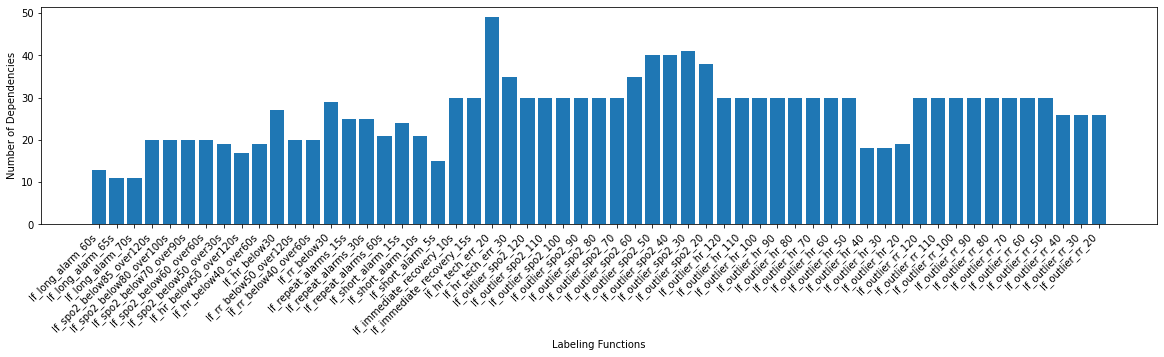

In [17]:
plt.figure(figsize=(20,4))
plt.bar(nodes_sorted[:,0], nodes_sorted[:,1])
plt.xticks(range(len(lfs)), lf_names, rotation=45, ha='right')
plt.xlabel('Labeling Functions')
plt.ylabel('Number of Dependencies')
plt.show()

#### Draw Dependency Graph

/home/sfpugh/Environments/smart_alarm_env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


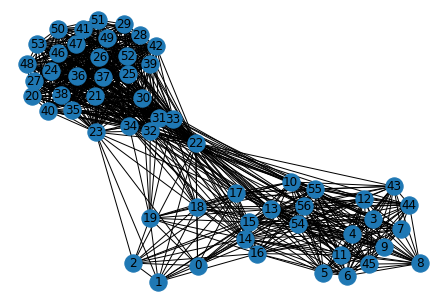

In [18]:
import networkx as nx

# define which dependencies to graph
deps = our_deps

G = nx.Graph()
G.add_edges_from(deps)
nx.draw(G, with_labels=True, font_size=12)

#### Observing the effect of p-value on number of dependencies

In [ ]:
from Our_Monitors.CD_Monitor_v1 import CDM

p_vals = 10 ** - np.arange(50, dtype=float)
n_deps = np.zeros(50)

for i, p_val in enumerate(p_vals):
    n_deps[i] = len( CDM(L_dev, Y_dev, k=2, sig=p_val, verbose=False) )

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(np.log10(p_vals[:21]), n_deps[:21])
plt.xticks(np.log10(p_vals[:21]))
plt.xlabel('p-value (log base 10)')
plt.ylabel('Number of Dependencies')
plt.show()

### Experiments for Reducing Dependencies

#### E1: Maximum Independent Set of LFs
This experiment chooses the maximum subset of LFs such that there are no dependencies between them and generates a model from that subset. The "maximum independent vertex set" algorithm is the key component to this experiment.

In [ ]:
from Our_Monitors.CD_Monitor_v1 import CDM
import igraph as ig
from collections import Counter

seed = 42
mis_stats = []         # list of tuples of number of MISs and their size per fold combo
best_mis_dicts = []    # list of dictionaries of best MISs per metric per fold combo
freq_lf_in_mis = np.zeros(len(lfs))    # frequency of each LF occuring in the MIS over all fold combos
metrics = ["accuracy","coverage","precision","recall","f1","roc_auc"]
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

for train_idx, dev_idx in kf.split(L_alarms):
    # Define training dataset
    L_train_all = L_alarms[train_idx]
    Y_train = alarms_df.true_label.values[train_idx]
    # Define development dataset
    L_dev = L_alarms[dev_idx]
    Y_dev = alarms_df.true_label.values[dev_idx]

    # Get edges of dependency graph from Conditional Dependency Monitor (CDM)
    our_deps = CDM(L_dev, Y_dev, k=2, sig=0.05, verbose=False)

    # Generate graph from dependencies and compute maximum independent set
    G = ig.Graph()
    G.add_vertices(len(lfs))
    G.add_edges(our_deps)
    max_indep_sets = G.largest_independent_vertex_sets()
    mis_stats.append( (len(max_indep_sets), len(max_indep_sets[0])) )

    # Log frequency of each lf appearing in the maximum independent set
    #temp = [lf for mis in max_indep_sets for lf in mis]    # flatten
    #for x in Counter(temp).items():
    #    freq_lf_in_mis[x[0]] = freq_lf_in_mis[x[0]] + x[1]
    #continue

    # For each max indep set, evaluate a model, output those with the best metric scores
    best_mis_per_metric = {m: (0.0,[]) for m in metrics}

    for mis in max_indep_sets:
        mis = list(mis)
        L_train = L_train_all[:,mis]
        l_model = LabelModel(cardinality=2, verbose=True)
        l_model.fit(L_train, log_freq=100, seed=seed)
        results = l_model.score(L_train, Y=Y_train, metrics=metrics)

        for key in best_mis_per_metric:
            if best_mis_per_metric[key][0] < results[key]:
                best_mis_per_metric[key] = (results[key], mis)

    best_mis_dicts.append(best_mis_per_metric)

In [ ]:
best_mis_dicts

In [ ]:
# Plot of frequency of LF being in MIS
plt.figure(figsize=(20,5))
plt.bar(range(len(lfs)), freq_lf_in_mis)
plt.xticks(range(len(lfs)), lf_names, rotation=45, ha='right')
plt.ylabel('Frequency of LF in MIS (over 5-fold CV)')
plt.show() 

In [ ]:
# Plot of frequency of LF-type being in MIS
lf_types = ['long_alarm','spo2_belowX_overT','hr_belowX_overT','rr_belowX_overT','repeat_alarms','short_alarm','immediate_recovery','hr_tech_err','spo2_outlier','hr_outlier','rr_outlier']

freq = []
freq.append(sum(freq_lf_in_mis[0:3]))    # long alarm
freq.append(sum(freq_lf_in_mis[3:8]))    # spo2 below over
freq.append(sum(freq_lf_in_mis[8:11]))   # hr below over
freq.append(sum(freq_lf_in_mis[11:14]))  # rr below over
freq.append(sum(freq_lf_in_mis[14:17]))  # repeat alarms
freq.append(sum(freq_lf_in_mis[17:20]))  # short alarm
freq.append(sum(freq_lf_in_mis[20:22]))  # imm recovery
freq.append(sum(freq_lf_in_mis[22:24]))  # hr tech err
freq.append(sum(freq_lf_in_mis[25:36]))  # spo2 outlier
freq.append(sum(freq_lf_in_mis[36:47]))  # hr outlier
freq.append(sum(freq_lf_in_mis[47:58]))  # rr outlier

plt.figure(figsize=(20,5))
plt.bar(range(len(lf_types)), freq)
plt.xticks(range(len(lf_types)), lf_types, rotation=45, ha='right')
plt.ylabel('Frequency of LF-type in MIS (over 5-fold CV)')
plt.show()

#### E2: Remove LFs with the Most Dependencies
This experiment removes LFs with the most dependencies until there are no dependencies left.

In [ ]:
from Our_Monitors.CD_Monitor_v2 import CDM, Informed_LabelModel
from snorkel.analysis import Scorer

seed = 42
metrics = ["accuracy","coverage","precision","recall","f1","roc_auc"]
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
results_arr = []

for train_idx, dev_idx in kf.split(L_alarms):
    # Define training dataset
    L_train_all = L_alarms[train_idx]
    Y_train = alarms_df.true_label.values[train_idx]
    # Define development dataset
    L_dev_all = L_alarms[dev_idx]
    Y_dev = alarms_df.true_label.values[dev_idx]
    
    lfs_subset = list(range(len(lfs)))
    
    # Get edges of dependency graph from Conditional Dependency Monitor (CDM)
    our_deps, nodes_sorted = CDM(L_dev_all, Y_dev, k=2, sig=0.05, verbose=False)
    
    while len(our_deps) != 0:
        # Remove LF with the most edges
        del lfs_subset[ nodes_sorted[0,0] ]
        L_dev = L_dev_all[:,lfs_subset]
        
        # Get edges of dependency graph from Conditional Dependency Monitor (CDM)
        our_deps, nodes_sorted = CDM(L_dev, Y_dev, k=2, sig=0.05, verbose=False)
    
    # Build model from remaining LFs
    L_train = L_train_all[:,lfs_subset]
    l_model = LabelModel(cardinality=2, verbose=True)
    l_model.fit(L_train, log_freq=100, seed=seed)
    
    # Evaluate model
    scores = l_model.score(L_train, Y=Y_train, metrics=metrics) 
    y_pred = l_model.predict(L_train)
    
    print('LFs Subset: ', lfs_subset)
    print('Confusion Matrix: \n', confusion_matrix(Y_train, y_pred))
    print('Abstain: ', np.sum(y_pred == ABSTAIN) / len(y_pred))
    print('Supress: ', np.sum(y_pred == SUPPRESSIBLE) / len(y_pred), '\n')
    print(scores)
    
    results_arr.append((lfs_subset,scores))

In [ ]:
results_arr